In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
import cmcrameri.cm as cmc
from scipy.ndimage import uniform_filter
import alphashape
from scipy.interpolate import splprep, splev
import warnings
warnings.filterwarnings('ignore')

#Set directories
working_dir = os.getcwd()

#Get mouse directory
mouse_demo_dir = os.path.dirname(working_dir)

In [2]:
#Import processed data
all_cells = pd.read_csv(os.path.join(mouse_demo_dir, 'Data', 'mouse_data_processing.csv'))
epi_nuc = all_cells[all_cells['Epiblast'] >= 1]

### Global gradients and local heterogeneity in relative space

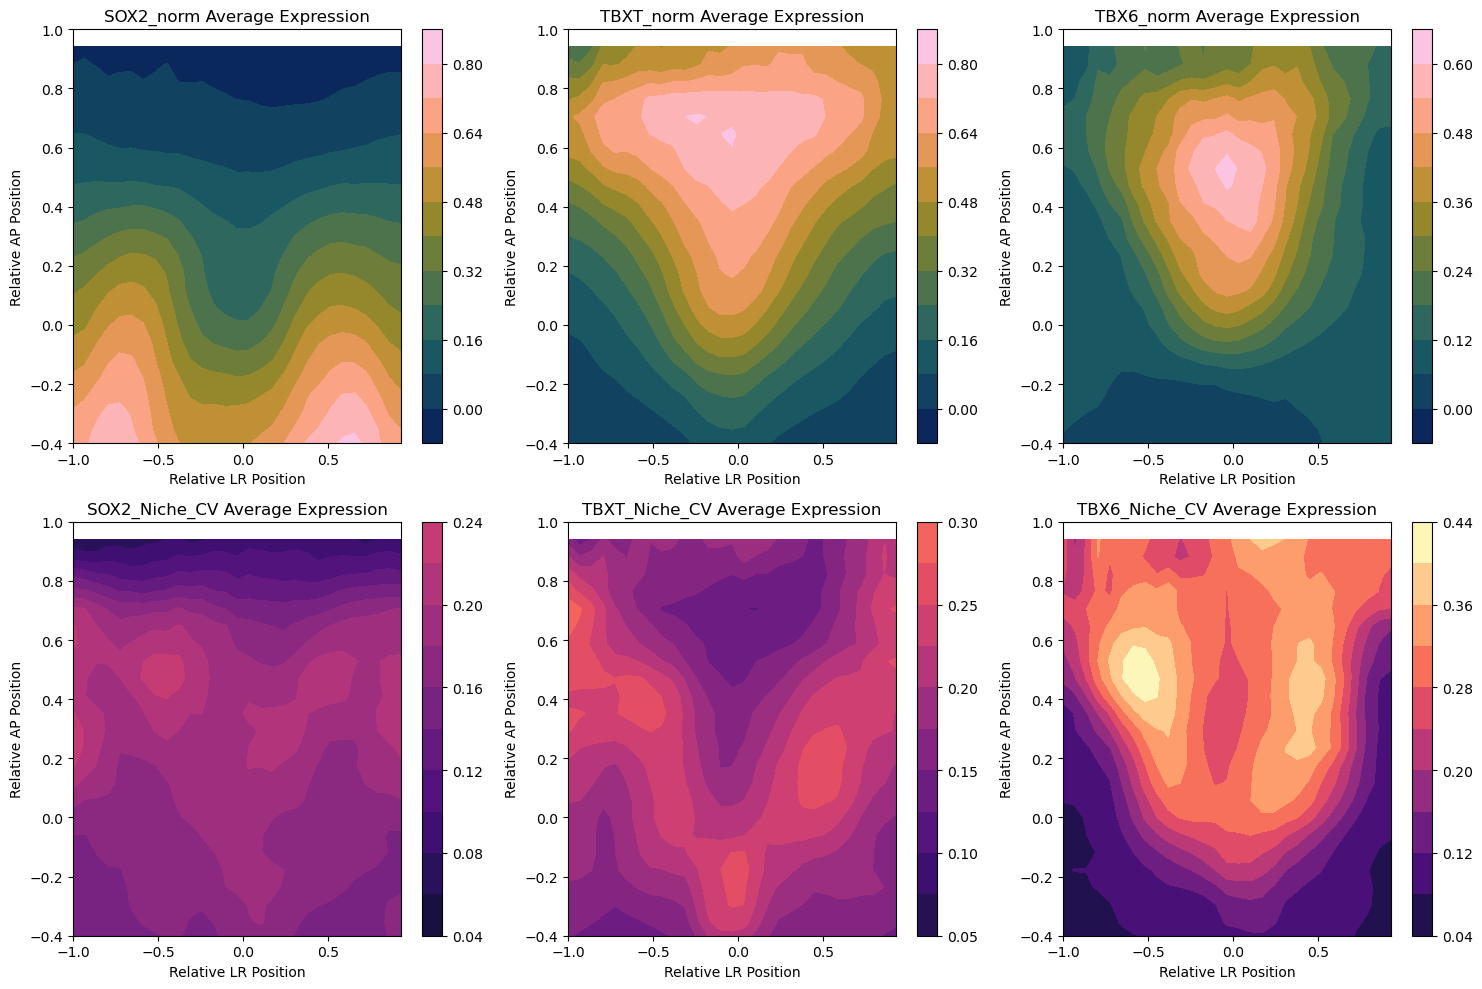

In [6]:
channels = ['SOX2_norm', 'TBXT_norm', 'TBX6_norm']
ycol = 'Rel_AP_position'
xcol = 'Rel_LR_position'

#Set y limits
ylim = (-0.4, 1)

# Define binning and smoothing parameters
n_bins = 30
smoothing = 5
x_bins = np.linspace(epi_nuc[xcol].min(), epi_nuc[xcol].max(), n_bins)
y_bins = np.linspace(epi_nuc[ycol].min(), epi_nuc[ycol].max(), n_bins)

# Store average data for each channel
channel_avg_data = {}

# Bin data and average per replicate 
for channel in channels:
    binned_data = []
    for embryo in epi_nuc['embryo'].unique():
        embryo_data = epi_nuc[epi_nuc['embryo'] == embryo]
        hist2d, _, _ = np.histogram2d((embryo_data[xcol]), 
                                        embryo_data[ycol], 
                                        bins=[x_bins, y_bins], 
                                        weights=embryo_data[channel])
        count, _, _ = np.histogram2d(embryo_data[xcol], 
                                    embryo_data[ycol], 
                                    bins=[x_bins, y_bins])
        avg = np.divide(hist2d, count, where=count != 0)
        binned_data.append(avg)

    # Average across embryos and store
    avg_data = np.nanmean(binned_data, axis=0)

    # Apply local mean smoothing
    smoothed_data = uniform_filter(avg_data, size=smoothing, cval=np.nan,
                                   mode='reflect')
    # Store smoothed data
    channel_avg_data[channel] = smoothed_data
    
# Create filled contour plots for all channels
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
count = 0
for idx, channel in enumerate(channels):
    X, Y = np.meshgrid(x_bins[:-1], y_bins[:-1])
    CS = axes[0, idx].contourf(X, Y, channel_avg_data[channel].T, cmap=cmc.batlow, levels=10)
    fig.colorbar(CS, ax=axes[0, idx])
    axes[0, idx].set_title(f'{channel} Average Expression')
    axes[0, idx].set_xlabel('Relative LR Position')
    axes[0, idx].set_ylabel('Relative AP Position')
    axes[0, idx].set_ylim(ylim)
    count += 1

#Now do the same for the CV of the channels
channels = ['SOX2_Niche_CV', 'TBXT_Niche_CV', 'TBX6_Niche_CV']

# Store average data for each channel
channel_avg_data = {}

# Bin data and average per replicate (e.g., per embryo)
for channel in channels:
    binned_data = []
    for embryo in epi_nuc['embryo'].unique():
        embryo_data = epi_nuc[epi_nuc['embryo'] == embryo]
        hist2d, _, _ = np.histogram2d((embryo_data[xcol]), 
                                        embryo_data[ycol], 
                                        bins=[x_bins, y_bins], 
                                        weights=embryo_data[channel])
        count, _, _ = np.histogram2d(embryo_data[xcol], 
                                    embryo_data[ycol], 
                                    bins=[x_bins, y_bins])
        avg = np.divide(hist2d, count, where=count != 0)
        binned_data.append(avg)

    # Average across embryos and store
    avg_data = np.nanmean(binned_data, axis=0)
    # Apply local mean smoothing
    smoothed_data = uniform_filter(avg_data, size=smoothing, mode='reflect')
    channel_avg_data[channel] = smoothed_data
    
# filter out cells outside the boundary
maxs = [np.nanmax(channel_avg_data[channel]) for channel in channels]
max_col_value = np.nanmax(maxs)

for idx, channel in enumerate(channels):
    X, Y = np.meshgrid(x_bins[:-1], y_bins[:-1])
    CS = axes[1, idx].contourf(X, Y, channel_avg_data[channel].T, cmap='magma', levels=10)
    fig.colorbar(CS, ax=axes[1, idx])
    axes[1, idx].set_title(f'{channel} Average Expression')
    axes[1, idx].set_xlabel('Relative LR Position')
    axes[1, idx].set_ylabel('Relative AP Position')
    axes[1, idx].set_ylim(ylim)
    # Set color limits for consistency
    CS.set_clim(0, max_col_value)
    count += 1



plt.tight_layout()
plt.show()


### GLobal gradients and local heterogeneity in scaled relative space

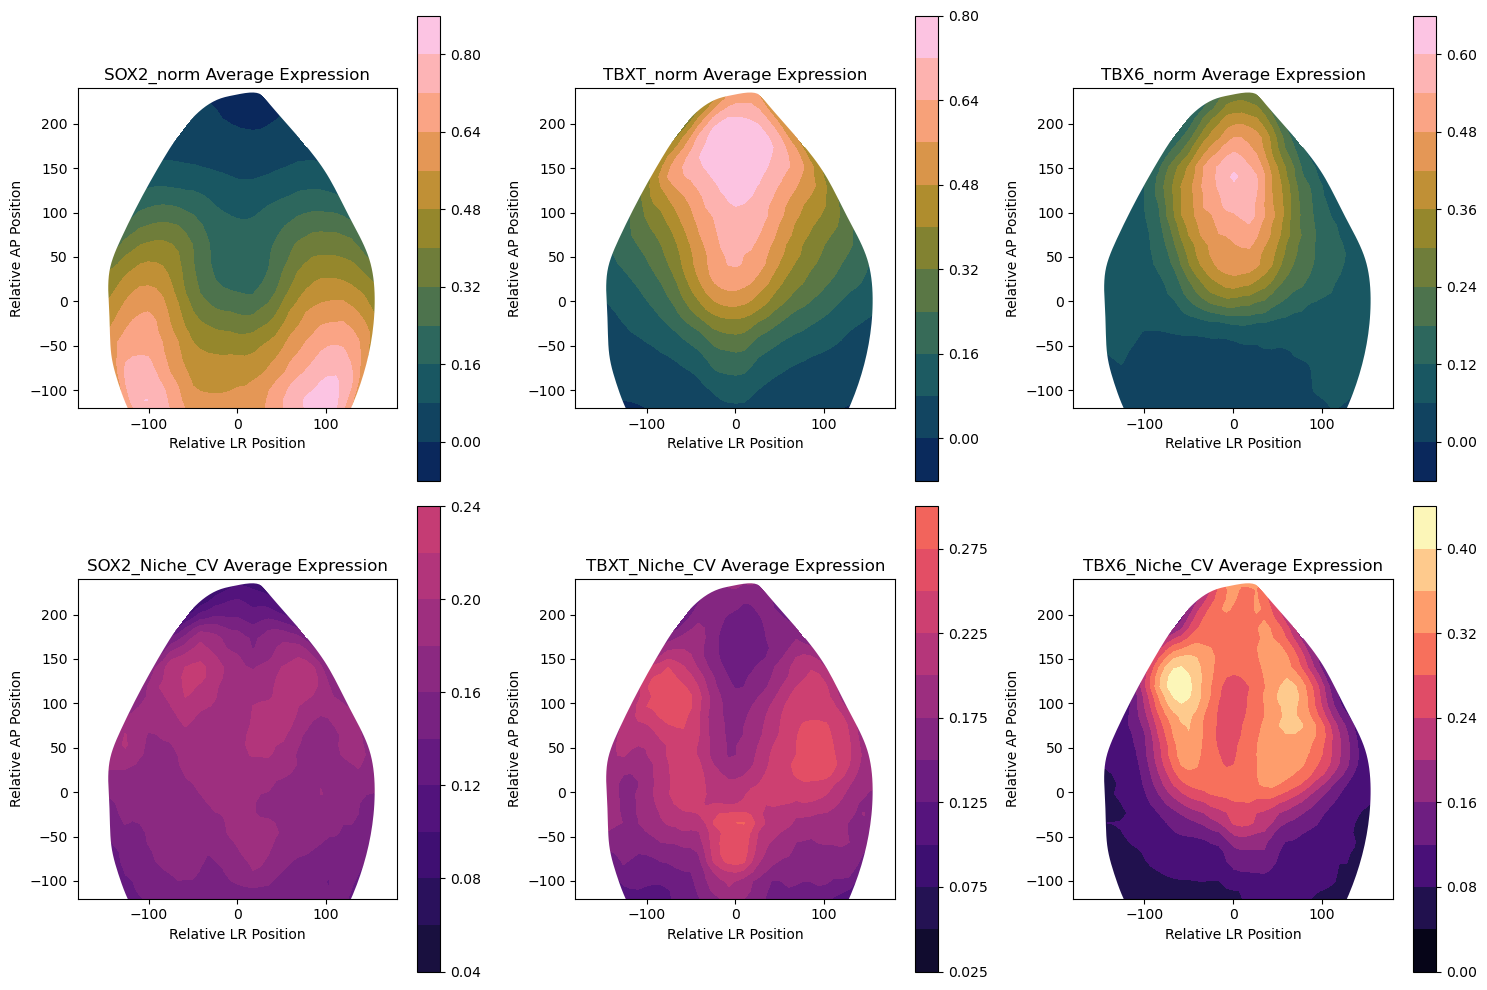

In [7]:
# Set figure channels
channels = ['SOX2_norm', 'TBXT_norm', 'TBX6_norm']
ycol = 'Scaled_Rel_AP_position'
xcol = 'Scaled_Rel_LR_position'

#Set y limits
ylim = (-120, 240)
xlim = (-180, 180)

# Define binning
n_bins = 40
smoothing = 6
x_bins = np.linspace(epi_nuc[xcol].min(), epi_nuc[xcol].max(), n_bins)
y_bins = np.linspace(epi_nuc[ycol].min(), epi_nuc[ycol].max(), n_bins)

outline_line_width = 20

# Store average data for each channel
channel_avg_data = {}

# Find embryo outline
points = epi_nuc[[xcol, ycol]].values

# Compute the Alpha Shape
alpha = 0.001  # Adjust alpha; lower values create a tighter fit
alpha_shape = alphashape.alphashape(points, alpha)
boundary_points = np.array(alpha_shape.exterior.coords)

# Spline interpolation for smooth boundary
tck, u = splprep(boundary_points.T, s=10)  # Adjust s for smoothness
smooth_boundary = splev(np.linspace(0, 1, 200), tck)

# Using same bins, count all cells in the area
full_count = []
for embryo in epi_nuc['embryo'].unique():
    embryo_data = epi_nuc[epi_nuc['embryo'] == embryo]
    hist2d, _, _ = np.histogram2d((embryo_data[xcol]), 
                                    embryo_data[ycol], 
                                    bins=[x_bins, y_bins])
    

    full_count.append(hist2d)

# Sum across embryos and store
full_count = np.nansum(full_count, axis=0)

# Bin data and average per replicate (e.g., per embryo)
for channel in channels:
    binned_data = []
    for embryo in epi_nuc['embryo'].unique():
        embryo_data = epi_nuc[epi_nuc['embryo'] == embryo]
        hist2d, _, _ = np.histogram2d((embryo_data[xcol]), 
                                        embryo_data[ycol], 
                                        bins=[x_bins, y_bins], 
                                        weights=embryo_data[channel])
        count, _, _ = np.histogram2d(embryo_data[xcol], 
                                    embryo_data[ycol], 
                                    bins=[x_bins, y_bins])
        avg = np.divide(hist2d, count, where=count != 0)
        binned_data.append(avg)

    # Average across embryos and store
    avg_data = np.nanmean(binned_data, axis=0)
    # Apply local mean smoothing
    smoothed_data = uniform_filter(avg_data, size=smoothing, mode='reflect')
    channel_avg_data[channel] = smoothed_data
    
# Create filled contour plots for all channels
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, channel in enumerate(channels):
    X, Y = np.meshgrid(x_bins[:-1], y_bins[:-1])
    values = channel_avg_data[channel]
    # Set values outside the boundary to NaN
    values[full_count == 0] = np.nan
    CS = axes[0, idx].contourf(X, Y, values.T, cmap=cmc.batlow, levels=10)
    fig.colorbar(CS, ax=axes[0, idx])
    axes[0, idx].set_title(f'{channel} Average Expression')
    axes[0, idx].set_xlabel('Relative LR Position')
    axes[0, idx].set_ylabel('Relative AP Position')
    axes[0, idx].set_ylim(ylim)
    axes[0, idx].plot(smooth_boundary[0], smooth_boundary[1], color='white', linewidth=outline_line_width)
    axes[0, idx].set_xlim(xlim)
    axes[0, idx].set_aspect('equal', adjustable='box')

#Now do the same for the CV of the channels
channels = ['SOX2_Niche_CV', 'TBXT_Niche_CV', 'TBX6_Niche_CV']

# Store average data for each channel
channel_avg_data = {}

# Bin data and average per replicate (e.g., per embryo)
for channel in channels:
    binned_data = []
    for embryo in epi_nuc['embryo'].unique():
        embryo_data = epi_nuc[epi_nuc['embryo'] == embryo]
        hist2d, _, _ = np.histogram2d((embryo_data[xcol]), 
                                        embryo_data[ycol], 
                                        bins=[x_bins, y_bins], 
                                        weights=embryo_data[channel])
        count, _, _ = np.histogram2d(embryo_data[xcol], 
                                    embryo_data[ycol], 
                                    bins=[x_bins, y_bins])
        avg = np.divide(hist2d, count, where=count != 0)
        binned_data.append(avg)

    # Average across embryos and store
    avg_data = np.nanmean(binned_data, axis=0)
    # Apply local mean smoothing
    smoothed_data = uniform_filter(avg_data, size=smoothing, mode='reflect')
    channel_avg_data[channel] = smoothed_data
    
# filter out cells outside the boundary
maxs = [np.nanmax(channel_avg_data[channel]) for channel in channels]
max_col_value = np.nanmax(maxs)

for idx, channel in enumerate(channels):
    X, Y = np.meshgrid(x_bins[:-1], y_bins[:-1])

    values = channel_avg_data[channel]
    # Set values outside the boundary to NaN
    values[full_count == 0] = np.nan

    CS = axes[1, idx].contourf(X, Y, values.T, cmap='magma', levels=10)
    axes[1, idx].plot(smooth_boundary[0], smooth_boundary[1], color='white', linewidth=outline_line_width)
    fig.colorbar(CS, ax=axes[1, idx])
    axes[1, idx].set_title(f'{channel} Average Expression')
    axes[1, idx].set_xlabel('Relative LR Position')
    axes[1, idx].set_ylabel('Relative AP Position')
    axes[1, idx].set_ylim(ylim)
    axes[1, idx].set_xlim(xlim)
    axes[1, idx].set_aspect('equal', adjustable='box')
    # Set color limits for consistency
    CS.set_clim(0, max_col_value)



plt.tight_layout()
plt.show()
